In [1]:
# Libraries
import numpy as np
SEED = 42 # set to 42
np.random.seed(SEED)

import pandas as pd
from pandas.tseries.offsets import BDay

from decimal import Decimal, getcontext
getcontext().prec = 15 # to be run within the target cells

import os

from FinDates.daycount import yearfrac
import datetime as dt
from datetime import datetime
from dateutil.relativedelta import relativedelta

from Final import (DC_CONV, 
                   depo_converter, 
                   future_converter, 
                   swap_converter, 
                   bootstrapDepo, 
                   bootstrapFuture, 
                   bootstrapSwap, 
                   getZeroRates, 
                   getRatesLinInterpDiscount,
                   interpZeroRate,
                   followingBday,
                   bootstrapCurves,
                   callEuropean,
                   deltaEuropean,
                   vegaEuropean)

from plotly.subplots import make_subplots
import plotly.graph_objects as pltgo

import matplotlib.pyplot as plt

# Suppress all warnings
import warnings
warnings.filterwarnings("ignore")

# Final project

## Problem settings

In [2]:
stock_name = 'ENEL'

S0 = price_at_settle = 6.13 # in euros per share (underlying price)
sigma = 0.16 # volatility
d = 0.04 # dividend yield
T = 4 # time period in years
#dt = 1/252 # timestep in years
alpha = 1.2
Spol = 200e-4 # Spread Over Libor, 200 basis points
K = 1
n_sim = 100000

# Day count convention
"""
Party A : Act/360
Party B : 30E/360
"""

'\nParty A : Act/360\nParty B : 30E/360\n'

## Bootstrap

First thing to do is performing the bootstrap as we are going to extensively use the outputs of the bootstrap during the project.

In [3]:
dt = pd.read_csv('data/dt.csv',
                index_col = 'Market',
                usecols = ['Market','TARGET'],
                converters = {'TARGET':pd.to_datetime})

today = dt.TARGET['Today']
dtSettle  = dt.TARGET['Settlement']

print('Today:', today)
print('Settlement Date (t_0):', dtSettle)

Today: 2008-02-15 00:00:00
Settlement Date (t_0): 2008-02-19 00:00:00


In [4]:
df_depo = pd.read_csv('data/depos.csv', 
                   index_col ='Depos',
                   usecols = ['Depos','ASK','BID'], 
                   converters={'Depos':pd.to_datetime,'BID':depo_converter,'ASK':depo_converter})

# print("Number of deposits:", df_depo.shape[0])
# sanity_check = df_depo["ASK"] > df_depo["BID"]
# print("\nAre all ASK > BID?", sanity_check.all()) # Check if all ASK > BID, deposits

futures = pd.read_csv('data/futures.csv',
                      index_col ='Future',
                      usecols = ['Future','ASK','BID'],
                      converters={'Future':pd.to_datetime,'BID':future_converter,'ASK':future_converter})

settle = pd.read_csv('data/settles.csv',
                     index_col = 'Future',
                     usecols =['Future', 'Settle', 'Expiry'], 
                     converters = {'Future':pd.to_datetime, 'Settle':pd.to_datetime, 'Expiry':pd.to_datetime})

df_futures = futures.join(settle)

df_swaps = pd.read_csv('data/swaps.csv',
                    index_col = 'Swap',
                    usecols = ['Swap','BID','ASK'],
                    converters={'Swap':pd.to_datetime,'BID':swap_converter,'ASK':swap_converter})

swapsYearFrac = [yearfrac(dtSettle, T, DC_CONV["SWAP"]) for T in df_swaps.index]

In [5]:
termDates = [dtSettle]  
discounts = [1.] 

termDates, discounts = bootstrapDepo(dtSettle, df_depo, df_futures, termDates, discounts)

termDates, discounts = bootstrapFuture(dtSettle, df_futures, termDates, discounts)

termDates, discounts = bootstrapSwap(dtSettle, df_swaps, termDates, discounts)

yearFrac = [yearfrac(dtSettle, T, DC_CONV["INTERP"]) for T in termDates[1:]] # converting all the term dates to year fractions according to ACT/365
zeroRates = getZeroRates(yearFrac, discounts[1:])

discCurve = pd.Series(index=pd.to_datetime(termDates), data=discounts)
zeroCurve = pd.Series(index=pd.to_datetime(termDates[1:]), data=zeroRates)

In [6]:
# Create subplots with shared x-axis and separate y-axes
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces to the subplots
fig.add_trace(
    pltgo.Scatter(x=discCurve.index, y=discCurve.values, opacity=0.8, mode='lines+markers', name='discounts'),
    secondary_y=False  # Primary y-axis
)
fig.add_trace(
    pltgo.Scatter(x=zeroCurve.index, y=zeroCurve.values, opacity=0.8, mode='lines+markers', name='z-rates'),
    secondary_y=True  # Secondary y-axis
)

# Customize the appearance of the y-axes
fig.update_yaxes(title_text="Discounts", secondary_y=False, tickfont=dict(color="blue"))  # Customize primary y-axis
fig.update_yaxes(title_text="Zero Rates", secondary_y=True, tickfont=dict(color="red"))  # Customize secondary y-axis

fig.update_layout(title="IR Bootstrap Curves",
                  xaxis_title="Time",
                  yaxis_title="Discounts",
                  legend_title="Legend")

# Show the figure
fig.show()

### Shifted Bootstrap

The shifted bootstrap is performed by shifting the rates (from different securities) used during the bootstrap process by 1 bps. Both discount curve and zero rate curve are bootstrapped using the shifted rates.

In [7]:
shift = 1e-4 # Spread over Libor
print("Shift:", shift, " (bps)")

Shift: 0.0001  (bps)


In [8]:
discCurve_shift, zeroCurve_shift, _, _ = bootstrapCurves(df_depo=df_depo, df_futures=df_futures, df_swaps=df_swaps, shift=shift)

In [9]:
# Create subplots with shared x-axis and separate y-axes
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces to the subplots
fig.add_trace(
    pltgo.Scatter(x=discCurve.index, y=discCurve_shift.values, opacity=0.8, mode='lines+markers', name='discounts'),
    secondary_y=False  # Primary y-axis
)
fig.add_trace(
    pltgo.Scatter(x=zeroCurve.index, y=zeroCurve_shift.values, opacity=0.8, mode='lines+markers', name='z-rates'),
    secondary_y=True  # Secondary y-axis
)

# Customize the appearance of the y-axes
fig.update_yaxes(title_text="Discounts", secondary_y=False, tickfont=dict(color="blue"))  # Customize primary y-axis
fig.update_yaxes(title_text="Zero Rates", secondary_y=True, tickfont=dict(color="red"))  # Customize secondary y-axis

fig.update_layout(title="IR Bootstrap Curves with Shift (1 bps)",
                  xaxis_title="Time",
                  yaxis_title="Discounts",
                  legend_title="Legend")

# Show the figure
fig.show()

In [10]:
# Create a subplot with shared x-axis and secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces to the subplots
fig.add_trace(
    pltgo.Scatter(x=discCurve.index, y=discCurve.values, opacity=0.8, mode='lines+markers', name='discounts'),
    secondary_y=False  # Primary y-axis
)
fig.add_trace(
    pltgo.Scatter(x=zeroCurve.index, y=zeroCurve.values, opacity=0.8, mode='lines+markers', name='z-rates'),
    secondary_y=True  # Secondary y-axis
)
fig.add_trace(
    pltgo.Scatter(x=discCurve.index, y=discCurve_shift.values, opacity=0.8, mode='lines+markers', name='discounts (1bp shift)'),
    secondary_y=False  # Primary y-axis
)
fig.add_trace(
    pltgo.Scatter(x=zeroCurve.index, y=zeroCurve_shift.values, opacity=0.8, mode='lines+markers', name='z-rates (1bp shift)'),
    secondary_y=True  # Secondary y-axis
)

# Customize the appearance of the y-axes
fig.update_yaxes(title_text="Discounts", secondary_y=False)  # Customize primary y-axis
fig.update_yaxes(title_text="Zero Rates", secondary_y=True)  # Customize secondary y-axis

fig.update_layout(
    title="IR Bootstrap Curves (Original vs Shifted by 1 bps)",
    xaxis_title="Time",
    legend_title="Legend"
)

# Show the figure
fig.show()


## Business Day Check

This section is used to check if the date is a business day or not. If the date is not a business day, the date is shifted to the next business day.

In [11]:
day = pd.Timestamp('2023-05-27')  # 27th May 2023 - Saturday
day.weekday()
print("Day of the week:", day.weekday() + 1)

f_day = followingBday(day)
print("Following Business Day:", f_day)

Day of the week: 6
Following Business Day: 2023-05-29 00:00:00


In [12]:
day = pd.Timestamp('2023-05-28')  # 28th May 2023 - Sunday
day.weekday()
print("Day of the week:", day.weekday() + 1)

f_day = followingBday(day)
print("Following Business Day:", f_day)

Day of the week: 7
Following Business Day: 2023-05-29 00:00:00


## Relevant days

We want to retrieve the relevant days for both Party A and Party B. The relevant days are the days when the cashflows are exchanged between the two parties. Every date is checked following the business day check and spot discount factors is calculated for each date, according to the proper day count convention for each party.

In [13]:
start_day = dtSettle # February 19th, 2008

maturity_day = start_day + relativedelta(years=4)
maturity_day = followingBday(maturity_day)

print("Start Day (Tuesday):", start_day)
print("Maturity Day (Monday):", maturity_day)

Start Day (Tuesday): 2008-02-19 00:00:00
Maturity Day (Monday): 2012-02-20 00:00:00


In [14]:
start_day

Timestamp('2008-02-19 00:00:00')

In [15]:
maturity_day

Timestamp('2012-02-20 00:00:00')

### Party A: quarterly, subject to following business day convention

In [16]:
# quarterly payment dates
payment_dates_A = [start_day + relativedelta(months=3 * i) for i in range(1, (4 * 4) + 1)]
payment_dates_A = [followingBday(d) for d in payment_dates_A]

payment_dates_A

[Timestamp('2008-05-19 00:00:00'),
 Timestamp('2008-08-19 00:00:00'),
 Timestamp('2008-11-19 00:00:00'),
 Timestamp('2009-02-19 00:00:00'),
 Timestamp('2009-05-19 00:00:00'),
 Timestamp('2009-08-19 00:00:00'),
 Timestamp('2009-11-19 00:00:00'),
 Timestamp('2010-02-19 00:00:00'),
 Timestamp('2010-05-19 00:00:00'),
 Timestamp('2010-08-19 00:00:00'),
 Timestamp('2010-11-19 00:00:00'),
 Timestamp('2011-02-21 00:00:00'),
 Timestamp('2011-05-19 00:00:00'),
 Timestamp('2011-08-19 00:00:00'),
 Timestamp('2011-11-21 00:00:00'),
 Timestamp('2012-02-20 00:00:00')]

In [17]:
zr_payment_dates_A = [interpZeroRate(start_day, date, termDates, discounts) for date in payment_dates_A]
disc_payment_dates_A = [np.exp(-zr * yearfrac(start_day, date, DC_CONV["PARTY_A"])) for date, zr in zip(payment_dates_A, zr_payment_dates_A)]

In [18]:
disc_payment_dates_A

[0.9893275583907681,
 0.9788564411336942,
 0.9694796885672654,
 0.9607284297053306,
 0.9525744687650304,
 0.9442354906176196,
 0.9358050928538152,
 0.9258354015947787,
 0.9170803001223348,
 0.9080923501959123,
 0.8991675761590292,
 0.8901139021632458,
 0.8814688951194966,
 0.8723436361905355,
 0.8630390659310103,
 0.8540520936725212]

### Party B: annualy, subject to following business day convention

In [19]:
# annual payment dates, coupon dates
payment_dates_B = [start_day + relativedelta(years=i) for i in range(1, 5)]
payment_dates_B = [followingBday(d) for d in payment_dates_B]

payment_dates_B

[Timestamp('2009-02-19 00:00:00'),
 Timestamp('2010-02-19 00:00:00'),
 Timestamp('2011-02-21 00:00:00'),
 Timestamp('2012-02-20 00:00:00')]

In [20]:
zr_payment_dates_B = [interpZeroRate(start_day, date, termDates, discounts) for date in payment_dates_B]
disc_payment_dates_B = [np.exp(-zr * yearfrac(start_day, date, DC_CONV["PARTY_B"])) for date, zr in zip(payment_dates_B, zr_payment_dates_B)]

In [21]:
disc_payment_dates_B

[0.961359622938438, 0.926909596835314, 0.8916250480825645, 0.85598964782303]

## Asian Option: Pricing

We use antithetic variates Monte Carlo simulation to price the Asian option (cumulated coupon payment).

In [22]:
def asian_option_pricer_MC(S0 = 6.13, 
                           K = 1,
                           sigma = 0.16, 
                           d = 0.04,
                           start_day = dtSettle, 
                           dates = payment_dates_B,
                           alpha = 1.2, 
                           n_sim = 100000, # default 100000
                           bs_dates = termDates,
                           bs_discounts = discounts,
                           seed = SEED):
    
    np.random.seed(seed)
    
    # ANTI-THETIC VARIATES MC
    g_pos = np.random.standard_normal(size=int(n_sim/2))
    g_neg = -g_pos
    g = np.concatenate([g_pos,g_neg])
    
    S_hist = [S0] # list average performances of the underlying
    payoff_hist = [] # list of average payoffs 
    delta_T = 0.0 # cumulative time interval
    dates = [start_day] + dates
    zero_rates = [] # list of zero rates through forward rates
    
    price = 0.0 # initial price
    t_0 = start_day # initial date
    S_init = S0 # initial price of the underlying
    
    for i in range(len(dates)-1):
        
        #np.random.seed(seed)
        
        # get the dates
        t_1 = dates[i]
        t_2 = dates[i+1]

        # retrieve the zero rates
        zR1 = interpZeroRate(t_0, t_1, bs_dates, bs_discounts)
        zR2 = interpZeroRate(t_0, t_2, bs_dates, bs_discounts)
        
        # get the discount factors
        B_01 = np.exp(-zR1 * yearfrac(t_0, t_1, DC_CONV["PARTY_B"]))
        if i == 0:
            B_01 = 1.0
        B_02 = np.exp(-zR2 * yearfrac(t_0, t_2, DC_CONV["PARTY_B"]))
        
        # compute the forward discount factor
        B_012 = B_02 / B_01
        
        # compute the time interval with proper day count convention
        delta_t = yearfrac(t_1, t_2, DC_CONV["PARTY_B"])
        
        # update the comulative time interval
        delta_T += delta_t
        
        # compute the corresponding forward zero rate
        z_012 = -np.log(B_012) / delta_t

        # append the zero rate to the history
        zero_rates.append(z_012)
        
        """
        CHECK: smoothness of the price wrt the underlying price
        """
        
        # compute the price of the underlying
        S = S_init * np.exp((z_012 - d - 0.5 * sigma**2) * delta_t + sigma * np.sqrt(delta_t) * g)
        
        # compute the average price of the underlying up to the current monitoring date
        S_init = np.mean(S)

        # append the price to the history
        S_hist.append(S_init)
        
        # collect all the monte carlo paths
        if i == 0:
            S_tn_mat = np.array(S)/S0
        else:
            S_tn_mat = np.column_stack((S_tn_mat, np.array(S)/S0))
        
        # compute the average performance of the underlying up to the current monitoring date
        if i == 0:
            S_tn = S_tn_mat # for i == 0, we have only one value
        else:
            S_tn = np.mean(S_tn_mat, axis=1) # considering the cumulative average performance over time
            
        
        # compute the payoffs for each path of the monte carlo simulation
        payoff = alpha * np.maximum(0, S_tn - K)
        
        # compute the average payoff for the current monitoring date
        payoff = np.mean(payoff) 
        
        # append the payoff to the history
        payoff_hist.append(payoff) # considering the average payoff of the average performance
        
        # update the price of the option up to the current monitoring date
        price += payoff * np.exp(-zR2 * delta_T) # discounting the payoffs
        
    #print("S_hist:", S_hist)
    #print("payoff_hist:", payoff_hist)
    #print("Elapsed time:", delta_T)
        
    return price, S_hist, payoff_hist, zero_rates

In [23]:
"""
Precision adjusted version of the asian_option_pricer_MC function
"""

def asian_option_pricer_MC_precision(S0=6.13, 
                           K=1,
                           sigma=0.16, 
                           d=0.04,
                           start_day=dtSettle, 
                           dates=payment_dates_B,
                           alpha=1.2, 
                           n_sim=100000,  
                           bs_dates=termDates,
                           bs_discounts=discounts,
                           seed=SEED):
    
    getcontext().prec = 15

    np.random.seed(seed)
    
    # ANTI-THETIC VARIATES MC
    g_pos = np.random.standard_normal(size=int(n_sim / 2))
    g_neg = -g_pos
    g = np.concatenate([g_pos, g_neg])
    
    S_hist = [S0]  # List average performances of the underlying
    payoff_hist = []  # List of average payoffs 
    delta_T = 0.0
    dates = [start_day] + dates
    zero_rates = []  # List of zero rates through forward rates
    
    price = Decimal(0.0)  # Initial price, using Decimal for precision
    t_0 = start_day  # Initial date
    S_init = S0  # Initial price of the underlying
    
    for i in range(len(dates) - 1):
        
        t_1 = dates[i]
        t_2 = dates[i + 1]
        
        zR1 = interpZeroRate(t_0, t_1, bs_dates, bs_discounts)
        zR2 = interpZeroRate(t_0, t_2, bs_dates, bs_discounts)
        
        B_01 = np.exp(-zR1 * yearfrac(t_0, t_1, DC_CONV["PARTY_B"]))
        if i == 0:
            B_01 = 1.0
        B_02 = np.exp(-zR2 * yearfrac(t_0, t_2, DC_CONV["PARTY_B"]))
        
        B_012 = B_02 / B_01
        
        delta_t = yearfrac(t_1, t_2, DC_CONV["PARTY_B"])
        
        delta_T += delta_t
        
        z_012 = -np.log(B_012) / delta_t
        
        zero_rates.append(z_012)
        
        S = S_init * np.exp((z_012 - d - 0.5 * sigma**2) * delta_t + sigma * np.sqrt(delta_t) * g)
        
        S_init = np.mean(S)
        
        S_hist.append(S_init)
        
        if i == 0:
            S_tn_mat = np.array(S) / S0
        else:
            S_tn_mat = np.column_stack((S_tn_mat, np.array(S) / S0))
        
        if i == 0:
            S_tn = S_tn_mat 
        else:
            S_tn = np.mean(S_tn_mat, axis=1) 
            
        payoff = alpha * np.maximum(0, S_tn - K)
        
        payoff = np.mean(payoff) 
        
        payoff_hist.append(payoff)  

        price += Decimal(payoff) * Decimal(np.exp(-zR2 * delta_T)) 
        
    return price, S_hist, payoff_hist, zero_rates


In [24]:
price, S_hist, payoff_hist, zero_rates = asian_option_pricer_MC(S0 = S0, 
                                                                K = K, 
                                                                sigma = sigma, 
                                                                d = d, 
                                                                start_day = dtSettle, 
                                                                dates = payment_dates_B, 
                                                                alpha = alpha, 
                                                                n_sim = n_sim, 
                                                                bs_dates = termDates, 
                                                                bs_discounts = discounts, 
                                                                seed = SEED)

In [25]:
print("Asian Option Price:", price)

Asian Option Price: 0.27269026782519046


In [26]:
S_hist # you can see the negative drift in the underlying price due to the dividend yield

[6.13,
 6.1263895604618535,
 6.10496418323128,
 6.096376088500899,
 6.101881386515016]

In [27]:
payoff_hist

[0.07615148816746109,
 0.07504534318766747,
 0.07445566317214636,
 0.07422346634865096]

In [28]:
zero_rates # forward zero rates

[0.039406722595989555,
 0.036492517867902315,
 0.038595922203135694,
 0.04090102608250377]

## Asian Option: Greeks

We compute the Greeks of the Asian option using the finite difference methods.

### Delta

In [29]:
S_vect = np.linspace(S0 - 1e-4, S0 + 1e-4 , 1000)
price_vect = []
price_vect_adj = []

for S in S_vect:
    price_, _, _, _ = asian_option_pricer_MC(S0=S)
    price_vect.append(price_)
    price_adj_, _, _, _ = asian_option_pricer_MC_precision(S0=S)
    price_vect_adj.append(price_adj_)

# Create a subplot with two traces
fig = make_subplots(rows=1, cols=1)

# Add original data trace
fig.add_trace(pltgo.Scatter(x=S_vect, y=price_vect, mode='lines', name='Original Option Price', opacity=0.8, line=dict(color='blue')), row=1, col=1)

# Add precision-adjusted data trace
fig.add_trace(pltgo.Scatter(x=S_vect, y=price_vect_adj, mode='lines', name='Precision Adjusted Option Price', opacity=0.8, line=dict(color='red')), row=1, col=1)

# Update axis titles
fig.update_xaxes(title_text='Underlying price', row=1, col=1)
fig.update_yaxes(title_text='Option price', row=1, col=1)

# Update layout
fig.update_layout(title='Option price vs Underlying price (Original vs Precision Adjusted)', 
                  height=600, 
                  width=1000, 
                  legend_title='Legend')  # legend settings

# Show the plot
fig.show()

In [30]:
"""

    Alternative way to compute the Delta: 
    
    - "Plain" version without precision adjustment
    - Precision adjusted version
    
"""

def Delta_Asian_FD(S0 = 6.13, h = 1e-3):
    
    # forward difference
    y, _, _, _ = asian_option_pricer_MC(S0 = S0)
    y_h, _, _, _ = asian_option_pricer_MC(S0 = S0 + h)
    
    # backward difference
    y_h_m, _, _, _ = asian_option_pricer_MC(S0 = S0 - h)
    
    # centered difference
    y_h_minus, _, _, _ = asian_option_pricer_MC(S0 = S0 - h/2)
    y_h_plus, _, _, _ = asian_option_pricer_MC(S0 = S0 + h/2)
    
    delta_B = (y - y_h_m) / h
    delta_F = (y_h - y) / h
    delta_C = (y_h_plus - y_h_minus) / h
    
    return delta_B, delta_F, delta_C


def Delta_Asian_FD_precision(S0=6.13, h=1e-3):
    
    getcontext().prec = 15
    
    # forward difference
    y, _, _, _ = asian_option_pricer_MC_precision(S0=S0)
    y_h, _, _, _ = asian_option_pricer_MC_precision(S0=S0 + h)
    
    # backward difference
    y_h_m, _, _, _ = asian_option_pricer_MC_precision(S0=S0 - h)
    
    # centered difference
    y_h_minus, _, _, _ = asian_option_pricer_MC_precision(S0=S0 - h/2)
    y_h_plus, _, _, _ = asian_option_pricer_MC_precision(S0=S0 + h/2)
    
    h = Decimal(str(h))
    
    delta_B = (y - y_h_m) / h
    delta_F = (y_h - y) / h
    delta_C = (y_h_plus - y_h_minus) / h
    
    return delta_B, delta_F, delta_C

In [31]:
h = 1e-6 

delta_B, delta_F, delta_C = Delta_Asian_FD(S0 = S0, h = h)


print("Delta Backward Difference:", delta_B)
print("Delta Forward Difference:", delta_F)
print("Delta Centered Difference:", delta_C)

delta_B, delta_F, delta_C = Delta_Asian_FD_precision(S0 = S0, h = h)

print("\nDelta Backward Difference (Precision):", delta_B)
print("Delta Forward Difference (Precision):", delta_F)
print("Delta Centered Difference (Precision):", delta_C)

Delta Backward Difference: 1.1102230246251565e-10
Delta Forward Difference: -1.1102230246251565e-10
Delta Centered Difference: -2.220446049250313e-10

Delta Backward Difference (Precision): 0E-9
Delta Forward Difference (Precision): 0E-9
Delta Centered Difference (Precision): 0E-9



h: 0.001
Delta Backward Difference: 1.1102230246251565e-13
Delta Forward Difference: 5.551115123125783e-14
Delta Centered Difference: -1.6653345369377348e-13

h: 0.0001
Delta Backward Difference: 2.220446049250313e-12
Delta Forward Difference: -1.1102230246251565e-12
Delta Centered Difference: 1.6653345369377348e-12

h: 1e-05
Delta Backward Difference: 2.2204460492503128e-11
Delta Forward Difference: 0.0
Delta Centered Difference: 5.551115123125782e-12

h: 1e-06
Delta Backward Difference: 1.1102230246251565e-10
Delta Forward Difference: -1.1102230246251565e-10
Delta Centered Difference: -2.220446049250313e-10

h: 1e-07
Delta Backward Difference: 1.1102230246251565e-09
Delta Forward Difference: -1.1102230246251565e-09
Delta Centered Difference: 1.1102230246251565e-09

h: 1e-08
Delta Backward Difference: 1.6653345369377348e-08
Delta Forward Difference: -1.1102230246251565e-08
Delta Centered Difference: -5.551115123125783e-09

h: 1e-09
Delta Backward Difference: 3.3306690738754696e-07
De

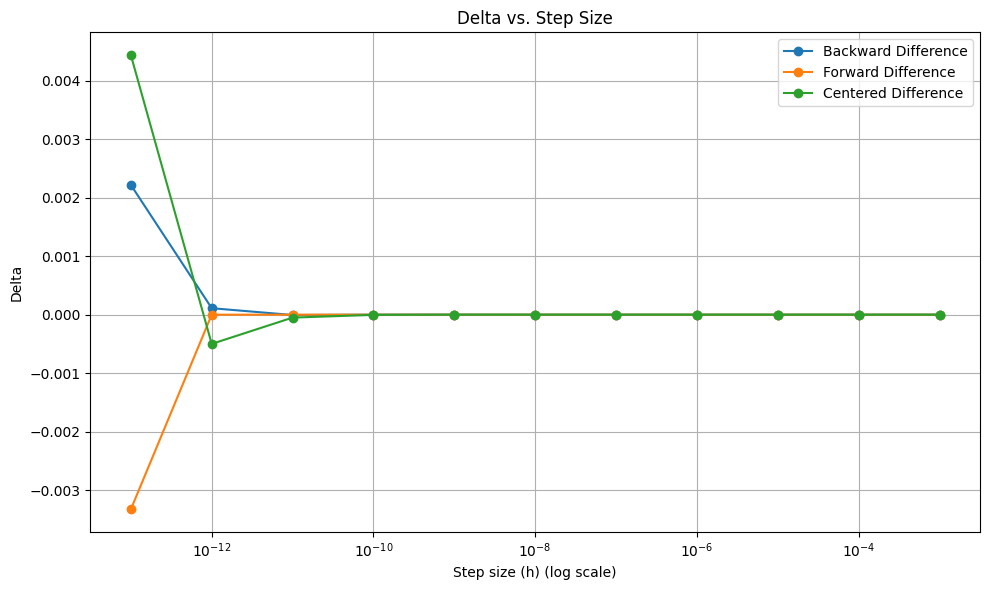

In [32]:
h_vect = [1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10, 1e-11, 1e-12, 1e-13]

delta_B_vect = []
delta_F_vect = []
delta_C_vect = []

for h in h_vect:
    print("\nh:", h)
    delta_B, delta_F, delta_C = Delta_Asian_FD(S0 = S0, h = h)
    delta_B_vect.append(delta_B)
    delta_F_vect.append(delta_F)
    delta_C_vect.append(delta_C)
    print("Delta Backward Difference:", delta_B)
    print("Delta Forward Difference:", delta_F)
    print("Delta Centered Difference:", delta_C)
    
# Plot
plt.figure(figsize=(10, 6))
plt.plot(h_vect, delta_B_vect, marker='o', linestyle='-', label='Backward Difference')
plt.plot(h_vect, delta_F_vect, marker='o', linestyle='-', label='Forward Difference')
plt.plot(h_vect, delta_C_vect, marker='o', linestyle='-', label='Centered Difference')
plt.xscale('log')
plt.xlabel('Step size (h) (log scale)')
plt.ylabel('Delta')
plt.title('Delta vs. Step Size')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
    


h: 0.001
Delta Backward Difference: 0E-12
Delta Forward Difference: 0E-12
Delta Centered Difference: 0E-12

h: 0.0001
Delta Backward Difference: 0E-11
Delta Forward Difference: 0E-11
Delta Centered Difference: 0E-11

h: 1e-05
Delta Backward Difference: 0E-10
Delta Forward Difference: 0E-10
Delta Centered Difference: 0E-10

h: 1e-06
Delta Backward Difference: 0E-9
Delta Forward Difference: 0E-9
Delta Centered Difference: 0E-9

h: 1e-07
Delta Backward Difference: 0E-8
Delta Forward Difference: 0E-8
Delta Centered Difference: 0E-8

h: 1e-08
Delta Backward Difference: 0E-7
Delta Forward Difference: 0E-7
Delta Centered Difference: 0E-7

h: 1e-09
Delta Backward Difference: 0.000000
Delta Forward Difference: 0.000000
Delta Centered Difference: 0.000000

h: 1e-10
Delta Backward Difference: 0.00000
Delta Forward Difference: 0.00000
Delta Centered Difference: 0.00000

h: 1e-11
Delta Backward Difference: 0.0000
Delta Forward Difference: 0.0000
Delta Centered Difference: 0.0000

h: 1e-12
Delta Ba

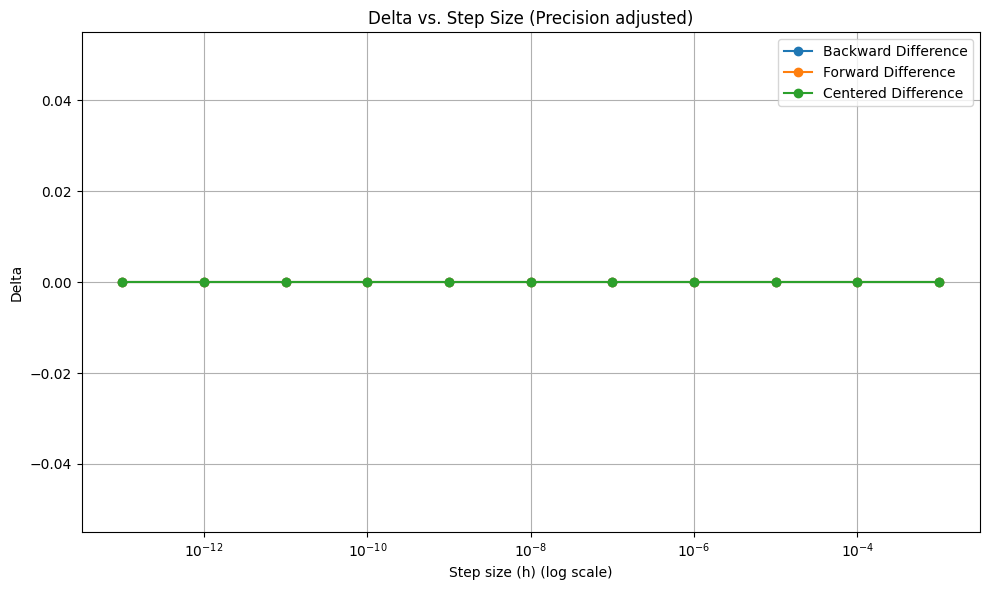

In [33]:
h_vect = [1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10, 1e-11, 1e-12, 1e-13]

delta_B_vect = []
delta_F_vect = []
delta_C_vect = []

for h in h_vect:
    print("\nh:", h)
    delta_B, delta_F, delta_C = Delta_Asian_FD_precision(S0 = S0, h = h)
    delta_B_vect.append(delta_B)
    delta_F_vect.append(delta_F)
    delta_C_vect.append(delta_C)
    print("Delta Backward Difference:", delta_B)
    print("Delta Forward Difference:", delta_F)
    print("Delta Centered Difference:", delta_C)
    
delta_asian = 0.0 # Asian Option Delta is analytically 0

# Plot
plt.figure(figsize=(10, 6))
plt.plot(h_vect, delta_B_vect, marker='o', linestyle='-', label='Backward Difference')
plt.plot(h_vect, delta_F_vect, marker='o', linestyle='-', label='Forward Difference')
plt.plot(h_vect, delta_C_vect, marker='o', linestyle='-', label='Centered Difference')
plt.xscale('log')
plt.xlabel('Step size (h) (log scale)')
plt.ylabel('Delta')
plt.title('Delta vs. Step Size (Precision adjusted)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Vega

In [34]:
sigma_vect = np.linspace(sigma - 1e-3, sigma + 1e-3 , 100)
price_vect = []
price_vect_adj = []

for sig in sigma_vect:
    price_, _, _, _ = asian_option_pricer_MC(sigma = sig)
    price_vect.append(price_)
    price_adj_, _, _, _ = asian_option_pricer_MC_precision(sigma = sig)
    price_vect_adj.append(price_adj_)

# Create a subplot with two traces
fig = make_subplots(rows=1, cols=1)

# Add original data trace
fig.add_trace(pltgo.Scatter(x=sigma_vect, y=price_vect, mode='lines', name='Original Option Price', opacity=0.8, line=dict(color='blue')), row=1, col=1)

# Add precision-adjusted data trace
fig.add_trace(pltgo.Scatter(x=sigma_vect, y=price_vect_adj, mode='lines', name='Precision Adjusted Option Price', opacity=0.8, line=dict(color='red')), row=1, col=1)

# Update axis titles
fig.update_xaxes(title_text='Underlying volatility', row=1, col=1)
fig.update_yaxes(title_text='Option price', row=1, col=1)

# Update layout
fig.update_layout(title='Option price vs Underlying volatility (Original vs Precision Adjusted)', 
                  height=600, 
                  width=1000, 
                  legend_title='Legend')  # legend settings

# Show the plot
fig.show()

In [35]:
"""

    Alternative way to compute the Vega: 
    
    - "Plain" version without precision adjustment
    - Precision adjusted version
    
"""

def Vega_Asian_FD(sigma = 0.16, h = 1e-3):
    
    # forward difference
    y, _, _, _ = asian_option_pricer_MC(sigma = sigma)
    y_h, _, _, _ = asian_option_pricer_MC(sigma = sigma + h)
    
    # centered difference
    y_h_minus, _, _, _ = asian_option_pricer_MC(sigma = sigma - h/2)
    y_h_plus, _, _, _ = asian_option_pricer_MC(sigma = sigma + h/2)
    
    vega_F = (y_h - y) / h
    vega_C = (y_h_plus - y_h_minus) / h
    
    return vega_F, vega_C

def Vega_Asian_FD_precision(sigma = 0.16, h = 1e-3):
    
    getcontext().prec = 15
    
    # forward difference
    y, _, _, _ = asian_option_pricer_MC_precision(sigma = sigma)
    y_h, _, _, _ = asian_option_pricer_MC_precision(sigma = sigma + h)
    
    
    # centered difference
    y_h_minus, _, _, _ = asian_option_pricer_MC_precision(sigma = sigma - h/2)
    y_h_plus, _, _, _ = asian_option_pricer_MC_precision(sigma = sigma + h/2)
    
    h = Decimal(str(h))
    
    vega_F = (y_h - y) / h
    vega_C = (y_h_plus - y_h_minus) / h
    
    return vega_F, vega_C

In [36]:
h = 1e-6

vega_F, vega_C = Vega_Asian_FD(sigma = sigma, h = h)

print("Vega Forward Difference:", vega_F)
print("Vega Centered Difference:", vega_C)

vega_F, vega_C = Vega_Asian_FD_precision(sigma = sigma, h = h)

print("\nVega Forward Difference (Precision):", vega_F)
print("Vega Centered Difference (Precision):", vega_C)

Vega Forward Difference: 1.7339093560941876
Vega Centered Difference: 1.7339093513202286

Vega Forward Difference (Precision): 1.733909357
Vega Centered Difference (Precision): 1.733909351



h: 0.001
Vega Forward Difference: 1.7338840404906852
Vega Centered Difference: 1.7339128059610243

h: 0.0001
Vega Forward Difference: 1.7339073752964396
Vega Centered Difference: 1.7339104331109967

h: 1e-05
Vega Forward Difference: 1.733910246631831
Vega Centered Difference: 1.7339097364676979

h: 1e-06
Vega Forward Difference: 1.7339093560941876
Vega Centered Difference: 1.7339093513202286

h: 1e-07
Vega Forward Difference: 1.733909346657292
Vega Centered Difference: 1.733909348877738

h: 1e-08
Vega Forward Difference: 1.733909332779504
Vega Centered Difference: 1.7339093660861948


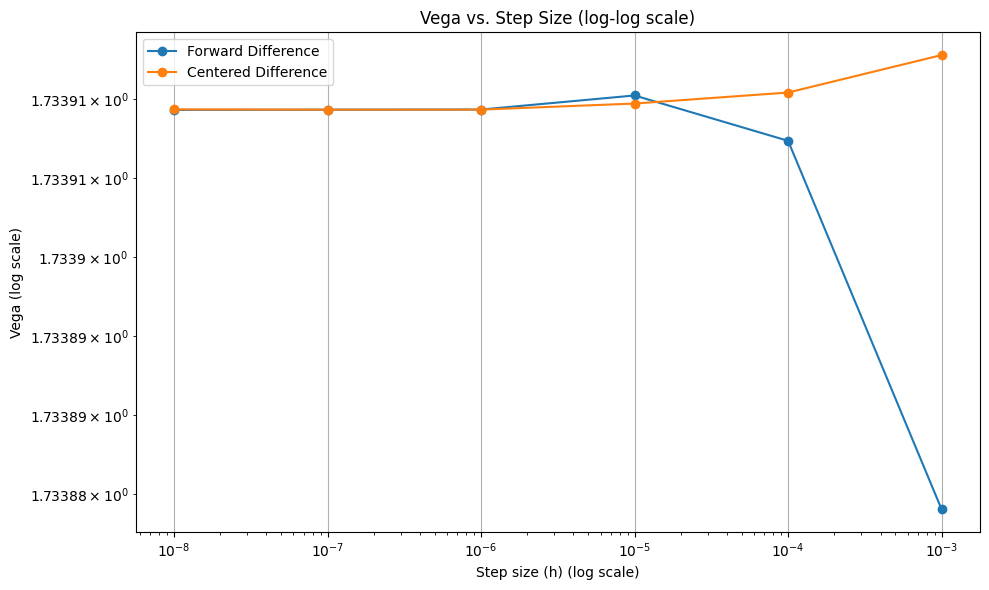

In [37]:
h_vect = [1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8]

vega_FD_vect = []
vega_CD_vect = []

for h in h_vect:
    print("\nh:", h)
    vega_F, vega_C = Vega_Asian_FD(sigma = sigma, h = h)
    vega_FD_vect.append(vega_F)
    vega_CD_vect.append(vega_C)
    print("Vega Forward Difference:", vega_F)
    print("Vega Centered Difference:", vega_C)

vega_asian = vega_CD_vect[3] # using vega centered difference with h = 1e-6

# Plot
plt.figure(figsize=(10, 6))
plt.plot(h_vect, vega_FD_vect, marker='o', linestyle='-', label='Forward Difference')
plt.plot(h_vect, vega_CD_vect, marker='o', linestyle='-', label='Centered Difference')
plt.xlabel('Step size (h) (log scale)')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('Vega (log scale)')
plt.title('Vega vs. Step Size (log-log scale)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


h: 0.001
Vega Forward Difference: 1.733884040492
Vega Centered Difference: 1.733912805962

h: 0.0001
Vega Forward Difference: 1.73390737530
Vega Centered Difference: 1.73391043310

h: 1e-05
Vega Forward Difference: 1.7339102467
Vega Centered Difference: 1.7339097365

h: 1e-06
Vega Forward Difference: 1.733909357
Vega Centered Difference: 1.733909351

h: 1e-07
Vega Forward Difference: 1.73390935
Vega Centered Difference: 1.73390935

h: 1e-08
Vega Forward Difference: 1.7339094
Vega Centered Difference: 1.7339093


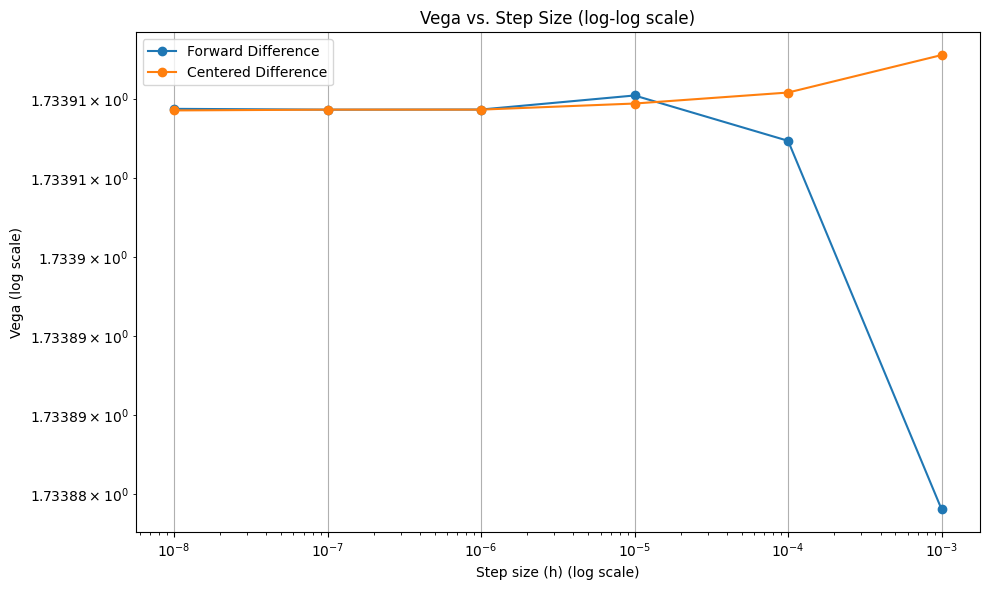

In [38]:
h_vect = [1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8]

vega_FD_vect = []
vega_CD_vect = []

for h in h_vect:
    print("\nh:", h)
    vega_F, vega_C = Vega_Asian_FD_precision(sigma = sigma, h = h)
    vega_FD_vect.append(vega_F)
    vega_CD_vect.append(vega_C)
    print("Vega Forward Difference:", vega_F)
    print("Vega Centered Difference:", vega_C)
    
# Plot
plt.figure(figsize=(10, 6))
plt.plot(h_vect, vega_FD_vect, marker='o', linestyle='-', label='Forward Difference')
plt.plot(h_vect, vega_CD_vect, marker='o', linestyle='-', label='Centered Difference')
plt.xlabel('Step size (h) (log scale)')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('Vega (log scale)')
plt.title('Vega vs. Step Size (log-log scale)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## NPVs and pricing of X%

Since a contract must be favorable for both parties, we price it by setting its total NPV equal to zero, meaning that $NPV_{PartyA} = NPV_{PartyB}$. By considering the inflows only, the NPVs are composed as follows:

$NPV_{PartyA} = X\% + NPV_{Asian}$;
$NPV_{PartyB} = NPV_{rate} + NPV_{Spol}$.

Furthermore, from now on, when we refer to the total NPV we mean the following:
$$
\begin{align*}
    NPV_{tot} &= NPV_{PartyA} - NPV_{PartyB} \\
    &= X\% + NPV_{Asian} - NPV_{rate} - NPV_{Spol}
\end{align*}
$$

X% is priced by setting the total NPV equal to zero, therefore:

$$
X\% = NPV_{rate} + NPV_{spol} - NPV_{asian}
$$


Once we have found the price of the asian option we can include it in the NPV computation (since it's already the sum of the discounted cash flows)

In [39]:
price, _, _, _ = asian_option_pricer_MC(S0 = S0, 
                                        K = K, 
                                        sigma = sigma, 
                                        d = d, 
                                        start_day = dtSettle, 
                                        dates = payment_dates_B, 
                                        alpha = alpha, 
                                        n_sim = n_sim, 
                                        bs_dates = termDates, 
                                        bs_discounts = discounts, 
                                        seed = SEED)

NPV_asian = price # price of the Asian Option is computed as the average of the payoffs discounted with the zero rates

print("NPV Asian Option:", NPV_asian)

NPV Asian Option: 0.27269026782519046


$$
\begin{align*}
    NPV_{rate} &= \sum_{i=0}^{n-1} B(t_0, t_i) - B(t_0, t_{i+1})  \\
    &= B(t_0, t_0) - B(t_0, t_n) \\
    &= 1 - B(t_0, t_n)
\end{align*}
$$

In [40]:
NPV_rate = 1 - disc_payment_dates_A[-1]

print("NPV Rate:", NPV_rate)

NPV Rate: 0.14594790632747878


$$
\begin{align*}
    NPV_{Spol} &= \sum_{i=1}^{n} S_{Spol} B(t_0, t_i) \\
    &= S_{Spol} \sum_{i=1}^{n} B(t_0, t_i)
\end{align*}
$$

In [41]:
NPV_Spol = Spol * np.sum(disc_payment_dates_A)

print("NPV Spol:", NPV_Spol)

NPV Spol: 0.2948440078236477


In [42]:
P = 100000000 # Principal Amount

X = NPV_rate + NPV_Spol - NPV_asian

print("X:", X)

print("Total up-front payment:", P*X)

X: 0.16810164632593605
Total up-front payment: 16810164.632593606


In [43]:
NPV_partyA = X + NPV_asian

NPV_partyB = NPV_rate + NPV_Spol

print("NPV Party A:", NPV_partyA)
print("NPV Party B:", NPV_partyB)

NPV Party A: 0.4407919141511265
NPV Party B: 0.4407919141511265


In [44]:
NPV_A_POV = NPV_partyA - NPV_partyB # Net Present Value of Party A Point of View, same as NPV_tot

print("NPV Party A POV:", NPV_A_POV)

NPV Party A POV: 0.0


## DV01 (before hedging)

In [45]:
def compute_NPV (zeroCurve, 
                 discCurve, 
                 payment_dates_A, 
                 payment_dates_B, 
                 Spol, 
                 alpha, 
                 S0, 
                 K, 
                 sigma, 
                 d, 
                 dtSettle, 
                 termDates, 
                 upfront = X,
                 n_sim = 100000, 
                 seed = SEED) :
    
    zr_payment_dates_A = [interpZeroRate(dtSettle, date, termDates, discCurve) for date in payment_dates_A]
    #zr_payment_dates_B = [interpZeroRate(dtSettle, date, termDates, discCurve) for date in payment_dates_B]
    
    disc_payment_dates_A = [np.exp(-zr * yearfrac(dtSettle, date, DC_CONV["PARTY_A"])) for date, zr in zip(payment_dates_A, zr_payment_dates_A)]
    #disc_payment_dates_B = [np.exp(-zr * yearfrac(dtSettle, date, DC_CONV["PARTY_B"])) for date, zr in zip(payment_dates_B, zr_payment_dates_B)]
    
    NPV_rate = 1 - disc_payment_dates_A[-1]
    
    print("NPV Rate:\t", NPV_rate)
    
    NPV_Spol = Spol * np.sum(disc_payment_dates_A)
    
    print("NPV Spol:\t", NPV_Spol)
    
    NPV_asian, _, _, _ = asian_option_pricer_MC(S0 = S0,
                                        K = K,
                                        sigma = sigma,
                                        d = d,
                                        start_day = dtSettle,
                                        dates = payment_dates_B,
                                        alpha = alpha,
                                        n_sim = n_sim,
                                        bs_dates = termDates,
                                        bs_discounts = discCurve,
                                        seed = seed)
    
    print("NPV Asian:\t", NPV_asian)
    
    NPV_partyA = upfront + NPV_asian
    
    print("NPV Party A:\t", NPV_partyA)
    
    NPV_partyB = NPV_rate + NPV_Spol
    
    print("NPV Party B:\t", NPV_partyB)
    
    NPV_A_POV = NPV_partyA - NPV_partyB
    
    print("NPV Party A POV:\t", NPV_A_POV)
    
    return NPV_A_POV, NPV_partyA, NPV_partyB

In [46]:
NPV_A_POV, NPV_partyA, NPV_partyB = compute_NPV(zeroCurve, 
                                                discCurve, 
                                                payment_dates_A, 
                                                payment_dates_B, 
                                                Spol, 
                                                alpha, 
                                                S0, 
                                                K, 
                                                sigma, 
                                                d, 
                                                dtSettle, 
                                                termDates,
                                                X,
                                                n_sim = 100000, 
                                                seed = SEED)

NPV Rate:	 0.14594790632747878
NPV Spol:	 0.2948440078236477
NPV Asian:	 0.27269026782519046
NPV Party A:	 0.4407919141511265
NPV Party B:	 0.4407919141511265
NPV Party A POV:	 0.0


In [47]:
def DVO1 (shift=1e-4, 
          NPV_A_old = 0.0,
          dtSettle = dtSettle,
          df_depo = df_depo,
          df_futures = df_futures,
          df_swaps = df_swaps):
      
    print("\nComputing DV01 ...\n")
    
    # using shifted curves
    discCurve_shift, zeroCurve_shift, _, _ = bootstrapCurves(dtSettle=dtSettle, df_depo=df_depo, df_futures=df_futures, df_swaps=df_swaps, shift=shift)
    
    NPV_A_POV_new, NPV_new_A, NPV_new_B = compute_NPV(zeroCurve_shift, discCurve_shift, payment_dates_A, payment_dates_B, Spol, alpha, S0, K, sigma, d, dtSettle, termDates, X, n_sim = 100000, seed = SEED)
    
    print("DV01:\t", NPV_A_POV_new - NPV_A_old)
    
    return NPV_A_POV_new - NPV_A_old, NPV_new_A, NPV_new_B

In [48]:
DV01_res, NPV_A_new, NPV_B_new = DVO1(shift=1e-4, NPV_A_old=NPV_A_POV, dtSettle=dtSettle, df_depo=df_depo, df_futures=df_futures, df_swaps=df_swaps)

print("\nDV01:", DV01_res)
print("NPV Party A New:", NPV_A_new)
print("NPV Party B New:", NPV_B_new)


Computing DV01 ...

NPV Rate:	 0.14628156371028678
NPV Spol:	 0.2947837888618075
NPV Asian:	 0.27300986198781496
NPV Party A:	 0.441111508313751
NPV Party B:	 0.4410653525720943
NPV Party A POV:	 4.61557416567282e-05
DV01:	 4.61557416567282e-05

DV01: 4.61557416567282e-05
NPV Party A New: 0.441111508313751
NPV Party B New: 0.4410653525720943


## Hedging

### Hedging $\mathcal{V}$

Before hedging, we need to retrieve the proper 4 years ATM-Fwd Europian Call option infos.

In [49]:
"""
ATM-Fwd European Call Option
"""

print("Start day:", start_day)
print("Maturity day:", maturity_day)

zr_ATM_fwd = interpZeroRate(start_day, maturity_day, termDates, discounts)
print("\nZero rate at maturity:", zr_ATM_fwd)

T = 4
S0 = 6.13 # initial price of the underlying
F0 = S0 * np.exp((zr_ATM_fwd - d)*T) # forward price
K = F0 # strike price set to the forward price as the option is ATM-Fwd
sigma = 0.16

print("Stock price:\t", S0)
print("Forward price:\t", F0)

Start day: 2008-02-19 00:00:00
Maturity day: 2012-02-20 00:00:00

Zero rate at maturity: 0.03884727187241848
Stock price:	 6.13
Forward price:	 6.101800169748639


In [50]:
price_eu_C = callEuropean(S0, K, T, zr_ATM_fwd, d, sigma)
delta_eu_C = deltaEuropean(S0, K, T, zr_ATM_fwd, d, sigma)
vega_eu_C = vegaEuropean(S0, K, T, zr_ATM_fwd, d, sigma)

print("European Call Option Delta:\t", delta_eu_C)
print("European Call Option price:\t", price_eu_C)
print("European Call Option Vega:\t", vega_eu_C)

European Call Option Delta:	 0.4802336960160685
European Call Option price:	 0.6640236867941245
European Call Option Vega:	 4.114854180046203


In order to hedge $\mathcal{V}$, since we are long on the Asian option, we need to short the ATM-Fwd Europian Call option. In particulat for each unit of Asian option we need to short $\frac{\mathcal{V}_{Asian}}{\mathcal{V}_{European}}$ units of the ATM-Fwd Europian Call option.

**Remark**: shorting the ATM-Fwd Europian Call option means that now our $\Delta$ is changed (negative).

In [51]:
vega_ratio = vega_asian / vega_eu_C

print(f'Vega of Asian Option = {vega_asian}')
print(f'Vega of European call option in the market = {vega_eu_C}\n')
print('=====================================')
print("[*] Sell {:.2f} European call options".format(vega_asian / vega_eu_C))
print('=====================================')

Vega of Asian Option = 1.7339093513202286
Vega of European call option in the market = 4.114854180046203

[*] Sell 0.42 European call options


In [52]:
"""
    New NPV function that takes into account the European Call Option
"""

def compute_NPV_eu (start_day = start_day,
                    maturity_day = maturity_day,
                    discCurve = discCurve, 
                    dates_A = payment_dates_A, 
                    dates_B = payment_dates_B, 
                    Spol = 200e-4, 
                    alpha = 1.2, 
                    S0 = 6.13, 
                    K = 1, 
                    sigma = 0.16, 
                    d = 0.04, 
                    start = dtSettle, 
                    termDates = termDates, 
                    upfront = X,
                    ratio = vega_ratio,
                    n_sim = 100000, 
                    seed = SEED):
    
    """
    Party A : $NPV_{float} = NPV_{rate} + NPV_{spol}$

    Party B: $NPV_{fixed} = X + NPV_{asian}$
    
    """
    
    zr_payment_dates_A = [interpZeroRate(start, date, termDates, discCurve) for date in payment_dates_A]
    #zr_payment_dates_B = [interpZeroRate(start, date, termDates, discCurve) for date in payment_dates_B]
    
    disc_payment_dates_A = [np.exp(-zr * yearfrac(start, date, DC_CONV["PARTY_A"])) for date, zr in zip(payment_dates_A, zr_payment_dates_A)]
    #disc_payment_dates_B = [np.exp(-zr * yearfrac(start, date, DC_CONV["PARTY_B"])) for date, zr in zip(payment_dates_B, zr_payment_dates_B)]
    
    NPV_rate = 1 - disc_payment_dates_A[-1]
    
    print("NPV Rate:\t", NPV_rate)
    
    NPV_Spol = Spol * np.sum(disc_payment_dates_A)
    
    print("NPV Spol:\t", NPV_Spol)
    
    NPV_asian, _, _, _ = asian_option_pricer_MC(S0 = S0,
                                        K = K,
                                        sigma = sigma,
                                        d = d,
                                        start_day = start,
                                        dates = payment_dates_B,
                                        alpha = alpha,
                                        n_sim = n_sim,
                                        bs_dates = termDates,
                                        bs_discounts = discCurve,
                                        seed = seed)
    
    print("NPV Asian:\t", NPV_asian)
    
    zr_ATM_fwd = interpZeroRate(start_day, maturity_day, termDates, discCurve)

    T = 4
    F0 = S0 * np.exp((zr_ATM_fwd - d)*T) # forward price
    K_eu = F0 # strike price set to the forward price as the option is ATM-Fwd
    
    NPV_eu = callEuropean(S0, K_eu, T, zr_ATM_fwd, d, sigma)
    
    print("NPV European:\t", NPV_eu)
    
    NPV_partyA_eu = upfront + NPV_asian + ratio * NPV_eu # already taking into account the vega ratio for vega neutral hedging
    
    print("NPV Party A:\t", NPV_partyA_eu)
    
    NPV_partyB_eu = NPV_rate + NPV_Spol
    
    print("NPV Party B:\t", NPV_partyB_eu)
    
    NPV_A_POV_eu = NPV_partyA_eu - NPV_partyB_eu
    
    print("NPV Party A POV:\t", NPV_A_POV_eu)
    
    return NPV_A_POV_eu, NPV_partyA_eu, NPV_partyB_eu

In [53]:
NPV_A_POV_eu, NPV_partyA_eu, NPV_partyB_eu = compute_NPV_eu()

print("\nNPV Party A POV (European):", NPV_A_POV_eu)
print("NPV Party A (European):", NPV_partyA_eu)
print("NPV Party B (European):", NPV_partyB_eu)

NPV Rate:	 0.14594790632747878
NPV Spol:	 0.2948440078236477
NPV Asian:	 0.27269026782519046
NPV European:	 0.6640236867941245
NPV Party A:	 0.7205969399558414
NPV Party B:	 0.4407919141511265
NPV Party A POV:	 0.2798050258047149

NPV Party A POV (European): 0.2798050258047149
NPV Party A (European): 0.7205969399558414
NPV Party B (European): 0.4407919141511265


In [54]:
def DV01_eu (shift=1e-4, 
             NPV_A_old = NPV_A_POV_eu,
             dtSettle = dtSettle,
             df_depo = df_depo,
             df_futures = df_futures,
             df_swaps = df_swaps):
      
    print("\nComputing DV01 ...\n")
    
    discCurve_shift, zeroCurve_shift, _, _ = bootstrapCurves(dtSettle=dtSettle, df_depo=df_depo, df_futures=df_futures, df_swaps=df_swaps, shift=shift)
    
    NPV_A_POV_new, NPV_new_A, NPV_new_B = compute_NPV_eu(discCurve=discCurve_shift)
    
    print("DV01:\t", NPV_A_POV_new - NPV_A_old)
    
    return NPV_A_POV_new - NPV_A_old, NPV_new_A, NPV_new_B    

In [55]:
DV01_eu()


Computing DV01 ...

NPV Rate:	 0.14628156371028678
NPV Spol:	 0.2947837888618075
NPV Asian:	 0.27300986198781496
NPV European:	 0.6640236867941254
NPV Party A:	 0.7209165341184663
NPV Party B:	 0.4410653525720943
NPV Party A POV:	 0.27985118154637206
DV01:	 4.615574165717229e-05


(4.615574165717229e-05, 0.7209165341184663, 0.4410653525720943)

### Hedging $\Delta$

Our asian option has $\Delta_{Asian} = 0$, so it may seem that we do not need to hedge it. However, we need to hedge the $\mathcal{V}_{Asian}$ first, and after Vega is hedged, we can hedge the $\Delta_{Asian}$.

In particular, as shorting the ATM-Fwd Europian Call option changes our $\Delta$ to negative, we need to buy $\left|\frac{\mathcal{V}_{European}}{\mathcal{V}_{Asian}} \times \Delta_{European}\right|$ units of the underlying asset.

In [56]:
print(f'Delta Asian option = {delta_asian}')
print(f'Delta European option = {delta_eu_C}')
print(f'Total delta of the portfolio = {delta_asian - (vega_asian / vega_eu_C) * delta_eu_C}\n')
delta_shares = delta_asian - (vega_asian / vega_eu_C) * delta_eu_C

action = ''
print('=====================================')
if delta_shares > 0:
    action = 'Sell'
else:
    action = 'Buy'
print(f"[*] {action} {abs(delta_shares)} shares of ENEl stock")
print('=====================================')

Delta Asian option = 0.0
Delta European option = 0.4802336960160685
Total delta of the portfolio = -0.20235995248122926

[*] Buy 0.20235995248122926 shares of ENEl stock


### Hedging DV01

To compute the DV01 of the swap, we first evaluate the NPV of the swap with the non-shifted IB bootstrap curve, then we shift this curve and calculate the new NPV of the swap. Finally, the DV01 is the difference between these two.

In [57]:
IRS_dates = payment_dates_A # exactly the same as the payment dates of party A

In [58]:
# compute NPV of the IRS

def compute_NPV_SWAP (start_day = start_day,
                      discCurve = discCurve,
                      termDates = termDates,
                      payment_dates_float = IRS_dates,
                      payment_dates_fixed = payment_dates_B,
                      S = 3.958 / 100,
                      N_value = 1):
    
    # floating leg
    zr = interpZeroRate(start_day, payment_dates_float[-1], termDates, discCurve)
    
    # exploiting telescopic sum for computing the NPV of the floating leg
    NPV_float = 1 - np.exp(-zr * yearfrac(start_day, payment_dates_float[-1], convention='ACT/360')) # ACT/360 day count convention for floating leg
    
    print("NPV Floating Leg:\t", NPV_float)
    
    # fixed leg
    S = 3.958 / 100 # fixed rate as mid BID/ASK
    
    zr_payment_dates = [interpZeroRate(start_day, date, termDates, discCurve) for date in payment_dates_fixed]
    
    NPV_fixed = N_value * S * np.sum([np.exp(-zr * yearfrac(start_day, date, DC_CONV["SWAP"])) for date, zr in zip(payment_dates_fixed, zr_payment_dates)])
    
    print("NPV Fixed Leg:\t", NPV_fixed)
    
    NPV = NPV_float - NPV_fixed # NPV of the swap from the perspective of the party A who pays the fixed leg and receives the floating leg
    
    print("NPV Swap:\t", NPV)
    
    return NPV_float, NPV_fixed, NPV

In [59]:
S_NPV_float, S_NPV_fixed, S_NPV = compute_NPV_SWAP(start_day=start_day, discCurve=discCurve, termDates=termDates, payment_dates_float=IRS_dates, payment_dates_fixed=payment_dates_B)

# print("NPV Float:", S_NPV_float)
# print("NPV Fixed:", S_NPV_fixed)
# print("NPV Swap:", S_NPV)

NPV Floating Leg:	 0.14594790632747878
NPV Fixed Leg:	 0.14390828538258854
NPV Swap:	 0.0020396209448902414


In [60]:
def DV01_SWAP (shift = 1e-4,
               start_day = start_day,
               discCurve = discCurve,
               termDates = termDates,
               payment_dates_float = IRS_dates,
               payment_dates_fixed = payment_dates_B):
    
    print("\nComputing DV01 SWAP ...\n")

    _, _, NPV_old = compute_NPV_SWAP(start_day=start_day, discCurve=discCurve, termDates=termDates, payment_dates_float=IRS_dates, payment_dates_fixed=payment_dates_B)
    
    print("\n---SHIFT---\n")
    
    discCurve_shift, _, _, _ = bootstrapCurves(dtSettle=start_day, df_depo=df_depo, df_futures=df_futures, df_swaps=df_swaps, shift=shift)
    
    _, _, NPV_new = compute_NPV_SWAP(start_day=start_day, discCurve=discCurve_shift, termDates=termDates, payment_dates_float=IRS_dates, payment_dates_fixed=payment_dates_B)
    
    return NPV_new - NPV_old

In [61]:
DV01_SWAP_res = DV01_SWAP(start_day=start_day, discCurve=discCurve, termDates=termDates, payment_dates_float=IRS_dates, payment_dates_fixed=payment_dates_B)

print("\nDV01 Swap:", DV01_SWAP_res)


Computing DV01 SWAP ...

NPV Floating Leg:	 0.14594790632747878
NPV Fixed Leg:	 0.14390828538258854
NPV Swap:	 0.0020396209448902414

---SHIFT---

NPV Floating Leg:	 0.14628156371028678
NPV Fixed Leg:	 0.1438741615309421
NPV Swap:	 0.002407402179344681

DV01 Swap: 0.00036778123445443955


In [62]:
DV01, _ , _ = DV01_eu() # DV01 of the portfolio with the European call option
print(f'\nThe DV01 of our portfolio is: {DV01}')
print(f'The DV01 of the 4y IR swap vs Euribor 3m is: {DV01_SWAP_res}')
ratio = DV01 / DV01_SWAP_res
print(f'The ratio between the two is: {ratio}\n')
tot_swap_amount = ratio * P  # since every DV01 variation is computed every 100$ of notional amount (check)
print('=====================================')
print(f'[*] Enter in a 4y IR swap vs Euribor 3m with notional amount = {tot_swap_amount}')
print('=====================================')


Computing DV01 ...

NPV Rate:	 0.14628156371028678
NPV Spol:	 0.2947837888618075
NPV Asian:	 0.27300986198781496
NPV European:	 0.6640236867941254
NPV Party A:	 0.7209165341184663
NPV Party B:	 0.4410653525720943
NPV Party A POV:	 0.27985118154637206
DV01:	 4.615574165717229e-05

The DV01 of our portfolio is: 4.615574165717229e-05
The DV01 of the 4y IR swap vs Euribor 3m is: 0.00036778123445443955
The ratio between the two is: 0.12549781591124118

[*] Enter in a 4y IR swap vs Euribor 3m with notional amount = 12549781.591124117


### Complete Hedging

In [63]:
total_delta = delta_asian - (vega_asian / vega_eu_C) * delta_eu_C - delta_shares
total_vega = vega_asian - (vega_asian / vega_eu_C) * vega_eu_C
total_DV01 = DV01 - ratio * DV01_SWAP_res

print('=====================================')
print(f"[*] Total Delta of the portfolio: {total_delta}")
print(f"[*] Total Vega of the portfolio: {total_vega}")
print(f"[*] Total DV01 of the portfolio: {total_DV01}")
print('=====================================')

[*] Total Delta of the portfolio: 0.0
[*] Total Vega of the portfolio: 0.0
[*] Total DV01 of the portfolio: 0.0


And we are successfully hedged!